In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

# Create a dataset
def generate_dataset(num_samples=100000, min_length=1, max_length=16):
    sequences = []
    labels = []
    for _ in range(num_samples):
        length = np.random.randint(min_length, max_length + 1)
        sequence = np.random.randint(2, size=length)
        count = np.sum(sequence)
        sequences.append(sequence)
        labels.append(count)
    return sequences, labels

sequences, labels = generate_dataset()


# splitting the dataset
train_size = int(0.8 * len(sequences))
val_size = int(0.1 * len(sequences))
test_size = len(sequences) - train_size - val_size

train_sequences = sequences[:train_size]
train_labels = labels[:train_size]

val_sequences = sequences[train_size:train_size + val_size]
val_labels = labels[train_size:train_size + val_size]

test_sequences = sequences[-test_size:]
test_labels = labels[-test_size:]

In [6]:
import numpy as np

def add_padding(sequences, max_length, padding_value=5):
    return [np.pad(seq, (0, max_length - len(seq)), constant_values=padding_value).tolist() for seq in sequences]


def remove_padding(padded_sequences, padding_value):
    return [seq[:seq.index(padding_value)] if padding_value in seq else seq for seq in padded_sequences]


In [7]:
train_sequences_padded = add_padding(train_sequences, max_length=16)
val_sequences_padded = add_padding(val_sequences, max_length=16)
test_sequences_padded = add_padding(test_sequences, max_length=16)

In [8]:

import torch
from torch.utils.data import Dataset, DataLoader

class BinarySequenceDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sequence, count = self.data[idx]
        return torch.tensor(sequence, dtype=torch.float32), count
    
train_data = list(zip(train_sequences_padded, train_labels))
val_data = list(zip(val_sequences_padded, val_labels))
test_data = list(zip(test_sequences_padded, test_labels))

train_dataset = BinarySequenceDataset(train_data)
val_dataset = BinarySequenceDataset(val_data)
test_dataset = BinarySequenceDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class RNNModel(nn.Module):
    def __init__(self, input_size, layers, hidden_size, output_size, dropout_prob=0.5, use_batchnorm=False, rnn_type='RNN'):
        super(RNNModel, self).__init__()
        
        # Select the type of RNN cell (RNN, LSTM, GRU)
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers=layers, batch_first=True, dropout=dropout_prob)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers=layers, batch_first=True, dropout=dropout_prob)
        else:
            self.rnn = nn.RNN(input_size, hidden_size, num_layers=layers, batch_first=True, dropout=dropout_prob)
        
        self.fc = nn.Linear(hidden_size, output_size)
        
        self.use_batchnorm = use_batchnorm
        if self.use_batchnorm:
            self.batch_norm = nn.BatchNorm1d(hidden_size)
        
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x, lengths):
        batch_size = x.size(0)
        
        # Initialize hidden state for RNN (zero initialization)
        h0 = torch.zeros(self.rnn.num_layers, batch_size, self.rnn.hidden_size).to(x.device)
        c0 = torch.zeros(self.rnn.num_layers, batch_size, self.rnn.hidden_size).to(x.device)
        
        packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        if isinstance(self.rnn, nn.LSTM):
            out, (hn, cn) = self.rnn(packed_x, (h0, c0))  # For LSTM
        else:
            out, hn = self.rnn(packed_x, h0)  # For RNN and GRU
        

        out_unpacked, _ = pad_packed_sequence(out, batch_first=True)
        
        idx = (torch.tensor(lengths) - 1).to(x.device)
        last_outputs = out_unpacked[torch.arange(batch_size), idx, :]
        
        if self.use_batchnorm:
            last_outputs = self.batch_norm(last_outputs)
        
        last_outputs = self.dropout(last_outputs)
        
        out = self.fc(last_outputs)
        
        return out


def process_batch(inputs, device):
    lengths = []
    filtered_sequences = []
    
    for seq in inputs:
        mask = seq != 5
        length = mask.sum().item()
        lengths.append(length)
    
    max_length = max(lengths)
    
    for seq in inputs:
        mask = seq != 5
        filtered_seq = seq[mask].float()
        padding_length = max_length - len(filtered_seq)
        padded = F.pad(filtered_seq, (0, padding_length), value=0)
        filtered_sequences.append(padded)
    
    filtered_inputs = torch.stack(filtered_sequences).to(device)
    
    return filtered_inputs.unsqueeze(-1), lengths

def calculate_accuracy(model, data_loader, device):
    model.eval()
    total_correct = 0
    total_samples = 0
    absolute_errors = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.float().to(device)
            
            # Process batch
            filtered_inputs, lengths = process_batch(inputs, device)
            
            outputs = model(filtered_inputs, lengths)
            predictions = outputs.squeeze().round()
            
            # Calculate accuracy
            correct = (predictions == targets).sum().item()
            total_correct += correct
            total_samples += len(targets)
            
            # Calculate absolute errors
            errors = torch.abs(predictions - targets)
            absolute_errors.extend(errors.cpu().numpy())
    
    accuracy = (total_correct / total_samples) * 100
    mean_absolute_error = sum(absolute_errors) / len(absolute_errors)
    
    # Return detailed statistics
    return {
        'accuracy': accuracy,
        'mean_absolute_error': mean_absolute_error,
        'total_correct': total_correct,
        'total_samples': total_samples
    }


def train_rnn_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    model.to(device)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.float().to(device)
            
            # Process batch
            filtered_inputs, lengths = process_batch(inputs, device)
            
            outputs = model(filtered_inputs, lengths)
            loss = criterion(outputs, targets.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        
        val_metrics = calculate_accuracy(model, val_loader, device)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_metrics['mean_absolute_error']}, Val Accuracy: {val_metrics['accuracy']}%")
    
    return model


# Run the Sample model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNModel(input_size=1, layers=1, hidden_size=64, output_size=1, dropout_prob=0.5, use_batchnorm=False, rnn_type='LSTM')

model = train_rnn_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, device=device)

print("\nFinal Test Set Evaluation:")
test_metrics = calculate_accuracy(model, test_loader, device)

# Print final results
print("\nFinal Results:")
print(f"Test Accuracy: {test_metrics['accuracy']}%")
print(f"Test Mean Absolute Error: {test_metrics['mean_absolute_error']}")
print(f"Correct Predictions: {test_metrics['total_correct']} out of {test_metrics['total_samples']}")

/home/keshava/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/10, Train Loss: 0.6160268534660339, Validation Loss: 0.0606, Val Accuracy: 94.24%
Epoch 2/10, Train Loss: 0.4210811133980751, Validation Loss: 0.0086, Val Accuracy: 99.21%
Epoch 3/10, Train Loss: 0.4012499520778656, Validation Loss: 0.0035, Val Accuracy: 99.67%
Epoch 4/10, Train Loss: 0.38132016596794127, Validation Loss: 0.0049, Val Accuracy: 99.53%
Epoch 5/10, Train Loss: 0.3630214674115181, Validation Loss: 0.0109, Val Accuracy: 98.92999999999999%
Epoch 6/10, Train Loss: 0.34570450105667117, Validation Loss: 0.0033, Val Accuracy: 99.67%
Epoch 7/10, Train Loss: 0.331175799036026, Validation Loss: 0.0008, Val Accuracy: 99.92%
Epoch 8/10, Train Loss: 0.31773247011899947, Validation Loss: 0.0008, Val Accuracy: 99.92%
Epoch 9/10, Train Loss: 0.3094479273557663, Validation Loss: 0.001, Val Accuracy: 99.9%
Epoch 10/10, Train Loss: 0.2986919649004936, Validation Loss: 0.0008, Val Accuracy: 99.92%

Final Test Set Evaluation:

Final Results:
Test Accuracy: 99.89%
Test Mean Absolute Er

In [11]:
def random_baseline_accuracy(data_loader):
    total_correct = 0
    total_samples = 0
    total_absolute_error = 0  # Accumulate absolute errors directly

    for inputs, targets in data_loader:
        # Generate random predictions within the range of possible values
        predictions = torch.randint(0, 17, targets.shape).float()

        # Calculate accuracy
        correct = (predictions == targets).sum().item()
        total_correct += correct
        total_samples += len(targets)

        # Accumulate absolute errors
        total_absolute_error += torch.abs(predictions - targets).sum().item()

    accuracy = (total_correct / total_samples) * 100
    mean_absolute_error = total_absolute_error / total_samples  # Use total_samples for MAE

    return {
        'accuracy': accuracy,
        'mean_absolute_error': mean_absolute_error,
        'total_correct': total_correct,
        'total_samples': total_samples
    }

# Display results
print("\nRandom Baseline Results:")
random_test_metrics = random_baseline_accuracy(test_loader)
print(f"Random Baseline Test Accuracy: {random_test_metrics['accuracy']}%")
print(f"Random Baseline Test Mean Absolute Error: {random_test_metrics['mean_absolute_error']}")
print(f"Correct Predictions: {random_test_metrics['total_correct']} out of {random_test_metrics['total_samples']}")



Random Baseline Results:
Random Baseline Test Accuracy: 6.1%
Random Baseline Test Mean Absolute Error: 5.4488
Correct Predictions: 610 out of 10000


In [11]:
# Experiment with different layers and different hidden states to figure out what works best
import itertools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

layers = [1, 2, ]
hidden_sizes = [64, 128]
results = []

# Use itertools.product to generate all possible combinations of layers and hidden sizes
for layers, hidden_size in itertools.product(layers, hidden_sizes):
    model = RNNModel(input_size=1, layers=layers, hidden_size=hidden_size, output_size=1, dropout_prob=0.2, use_batchnorm=True, rnn_type='LSTM')
    model = train_rnn_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, device=device)
    
    test_metrics = calculate_accuracy(model, test_loader, device)
    
    results.append({
        'layers': layers,
        'hidden_size': hidden_size,
        'accuracy': test_metrics['accuracy'],
        'mean_absolute_error': test_metrics['mean_absolute_error']
    })

# Print results
for result in results:
    print(f"Layers: {result['layers']}, Hidden Size: {result['hidden_size']}, Accuracy: {result['accuracy']}%, MAE: {result['mean_absolute_error']}")


/home/keshava/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/10, Train Loss: 0.972279708480835, Validation Loss: 0.0123, Val Accuracy: 98.86%
Epoch 2/10, Train Loss: 0.4827766265273094, Validation Loss: 0.0086, Val Accuracy: 99.27%
Epoch 3/10, Train Loss: 0.44380475038290024, Validation Loss: 0.0059, Val Accuracy: 99.41%
Epoch 4/10, Train Loss: 0.4270125570654869, Validation Loss: 0.0221, Val Accuracy: 97.84%
Epoch 5/10, Train Loss: 0.4130957518339157, Validation Loss: 0.017, Val Accuracy: 98.3%
Epoch 6/10, Train Loss: 0.4051220276117325, Validation Loss: 0.0743, Val Accuracy: 92.57%
Epoch 7/10, Train Loss: 0.3988021783828735, Validation Loss: 0.1552, Val Accuracy: 84.48%
Epoch 8/10, Train Loss: 0.39506457277536394, Validation Loss: 0.0006, Val Accuracy: 99.94%
Epoch 9/10, Train Loss: 0.3875938363790512, Validation Loss: 0.0, Val Accuracy: 100.0%
Epoch 10/10, Train Loss: 0.3858893027305603, Validation Loss: 0.0, Val Accuracy: 100.0%
Epoch 1/10, Train Loss: 0.875579022860527, Validation Loss: 0.1758, Val Accuracy: 82.53%
Epoch 2/10, Train

/home/keshava/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/10, Train Loss: 0.9978674734592438, Validation Loss: 0.1641, Val Accuracy: 85.18%
Epoch 2/10, Train Loss: 0.485126256608963, Validation Loss: 0.048, Val Accuracy: 95.33%
Epoch 3/10, Train Loss: 0.4492491455435753, Validation Loss: 0.0661, Val Accuracy: 93.46%
Epoch 4/10, Train Loss: 0.42884698712825775, Validation Loss: 0.0046, Val Accuracy: 99.64%
Epoch 5/10, Train Loss: 0.41850123550891877, Validation Loss: 0.0045, Val Accuracy: 99.7%
Epoch 6/10, Train Loss: 0.4086974022746086, Validation Loss: 0.0047, Val Accuracy: 99.72999999999999%
Epoch 7/10, Train Loss: 0.4013143324494362, Validation Loss: 0.0003, Val Accuracy: 99.97%
Epoch 8/10, Train Loss: 0.3965245455265045, Validation Loss: 0.0003, Val Accuracy: 99.97%
Epoch 9/10, Train Loss: 0.3893928443789482, Validation Loss: 0.0002, Val Accuracy: 99.98%
Epoch 10/10, Train Loss: 0.3849271900296211, Validation Loss: 0.0001, Val Accuracy: 99.99%
Mean Absolute Error for Sequence Length 1: 0.16006429028511046
Mean Absolute Error for S

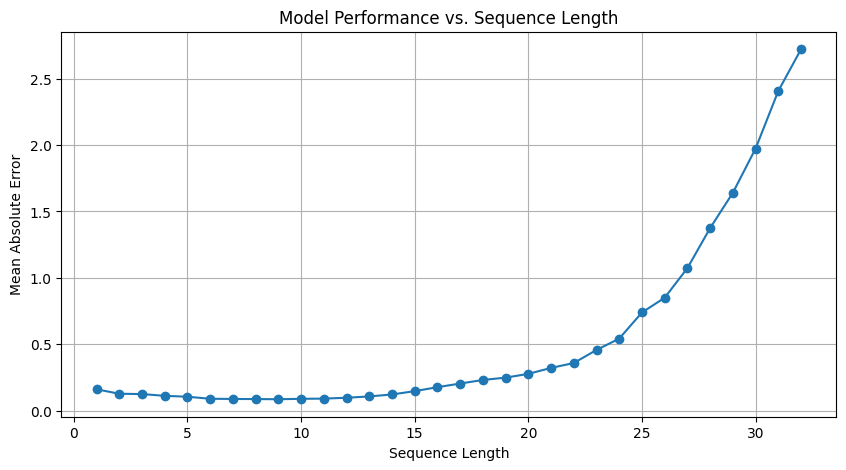

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def generate_variable_length_data(num_samples, seq_length):
    sequences = []
    labels = []
    
    for _ in range(num_samples):
        seq = torch.randint(0, 2, (seq_length,))
        label = seq.sum().item()
        sequences.append(seq)
        labels.append(label)
    
    return torch.stack(sequences), torch.tensor(labels)


def evaluate_sequence_length(model, seq_length, num_samples, device):
    sequences, labels = generate_variable_length_data(num_samples, seq_length)
    
    dataset = TensorDataset(sequences, labels)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    
    model.eval()
    total_mae = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.float().to(device)
            
            # Process batch (no need to handle padding since all sequences are same length)
            filtered_inputs = inputs.float().unsqueeze(-1)
            lengths = [seq_length] * inputs.size(0)
            
            outputs = model(filtered_inputs, lengths)
            mae = torch.abs(outputs.squeeze() - targets).mean().item()
            total_mae += mae * len(targets)
            total_samples += len(targets)
    
    return total_mae / total_samples


model = RNNModel(input_size=1, layers=1, hidden_size=64, output_size=1, dropout_prob=0.2, use_batchnorm=True, rnn_type='LSTM')
model = train_rnn_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, device=device)

# Evaluate model on sequences of different lengths
seq_lengths = [i for i in range(1, 33)]
mae_results = []

for seq_length in seq_lengths:
    mae = evaluate_sequence_length(model, seq_length, 1000, device)
    mae_results.append(mae)
    print(f"Mean Absolute Error for Sequence Length {seq_length}: {mae}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(seq_lengths, mae_results, marker='o')
plt.title("Model Performance vs. Sequence Length")
plt.xlabel("Sequence Length")
plt.ylabel("Mean Absolute Error")
plt.grid(True)
plt.show()

The model is not able to predict correctly only till 16 length sequence because we the trained is only remenbering upto 16 elemnets. So, As the length of the sequence increases the model is not able to predict correctly. That is why the MAE is increasing as the length of the sequence increases.